<a href="https://colab.research.google.com/github/blackscreen-whitetext/AIDS/blob/main/UMC301_Assignment_1b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UMC 301
## Assignment 1b

###Submission instructions:


1.   The assignment is to be submitted in ONE single notebook.
2.   Submit the .ipynb file and pdf of the same with all cells open through this Teams Assignment.
3. If your IISc email ID is < username > @iisc.ac.in, then name the file < username >_Assgn_1b. E.g. jonathan_Assgn_1b for email ID jonathan@iisc.ac.in.
4. Before submission, execute the ’Restart session and run all’ option from the Runtime/Kernel tab. Verify that there are no errors and that you are getting the output you expect.
5. Use the dataset **'SeoulBikeData.csv'**: https://www.dropbox.com/scl/fi/tofrz23mx38tbsrtar1lx/SeoulBikeData.csv?rlkey=zlvra2py146p5lrynxnzijc1p&dl=1


# Use XGBoost regression model to predict the bike count required at each hour for the stable supply of rental bikes.

###**Data Description**

###  The dataset contains weather information (Temperature, Humidity, Windspeed, Visibility, Dewpoint, Solar radiation, Snowfall, Rainfall), the number of bikes rented per hour and date information.


**Attribute Information:**

*  Date : dd/mm/yyyy
*  Rented Bike count - Count of bikes rented at each hour
*  Hour - Hour of he day
* Temperature-Temperature in Celsius
* Humidity - %
* Windspeed - m/s
* Visibility - 10m
* Dew point temperature - Celsius
* Solar radiation - MJ/m2
* Rainfall - mm
* Snowfall - cm
* Seasons - Winter, Spring, Summer, Autumn
* Holiday - Holiday/No holiday
*  Functional Day - No(Non Functional Hours), Yes(Functional hours)

##a. Data preprocessing

1. Import modules and load data.
2. Feature engineering
  * Check for null and duplicates in the data.
  * Add weekend data, month data.
  * Identify the datatypes.
  * Check whether all int/float datatypes falls into numerical feature category.
  * Seperate features into numerical and categorical.



In [4]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn import XGBRegressor

In [35]:
data = pandas.read_csv('SeoulBikeData.csv')
data.head()
# Check for null values
print(data.isnull().sum())

# Check for duplicates
print(data.duplicated().sum())
data['Month'] = pd.to_datetime(data['Date'], format='%d/%m/%y').dt.month
data["Is_weekend"] = pd.to_datetime(data['Date'], format='%d/%m/%y').dt.weekday.apply(lambda x: 1 if x > 4 else 0)
#data["Is_weekend"].value_counts()
data.drop(['Date'], axis=1, inplace=True)
print(data.dtypes)
categorical_features = ["Hour",'Seasons', 'Holiday', 'Functioning Day',"Month","Is_weekend"]
categorical_data = data[categorical_features]
numerical_data = data.drop(categorical_features, axis=1)

Date                        0
Rented Bike Count           0
Hour                        0
Temperature(C)              0
Humidity(%)                 0
Wind speed (m/s)            0
Visibility (10m)            0
Dew point temperature(C)    0
Solar Radiation (MJ/m2)     0
Rainfall(mm)                0
Snowfall (cm)               0
Seasons                     0
Holiday                     0
Functioning Day             0
dtype: int64
0
Rented Bike Count             int64
Hour                          int64
Temperature(C)              float64
Humidity(%)                   int64
Wind speed (m/s)            float64
Visibility (10m)              int64
Dew point temperature(C)    float64
Solar Radiation (MJ/m2)     float64
Rainfall(mm)                float64
Snowfall (cm)               float64
Seasons                      object
Holiday                      object
Functioning Day              object
Month                         int32
Is_weekend                    int64
dtype: object


##b.  Data visualization and encoding

1. Visualize how the rented bike count varies hourly for different categorical features.
2. Visualize the rented bike count outliers for each categorical features.
3. Visualize the variation in the data distribution for each numerical features. Also, mark/show the mean and median of the distribution in the plot.
4. Visualize the outliers in each numerical feature data.
5. create a regression plot to know relation between dependent and independent nuumerical variables.
6. Visualize the correlation between different numerical features using heat map. Find and remove correlated features for a threshold value of 0.7 (correlation>0.7).

  **Comment your analysis from each plots.**

7. Encoding categorical features (**Use pipelines**).
  * One-hot encoding for seasons.
  * Numerical encoding (1 or 0) for categorical features with 2 unique values.
  * Use numerical identifier for other categorical features (eg. month: January-1, march-3)
8. Delete non-relevant feautes from the dataframe and comment.
9. Visualize the dependent variable data-distribution and check for skewness. The regression assumes that the dependent variable has a nearly normal distribution, therefore, to meet this assumption, make some measures to normalize the distribution, if necessary.

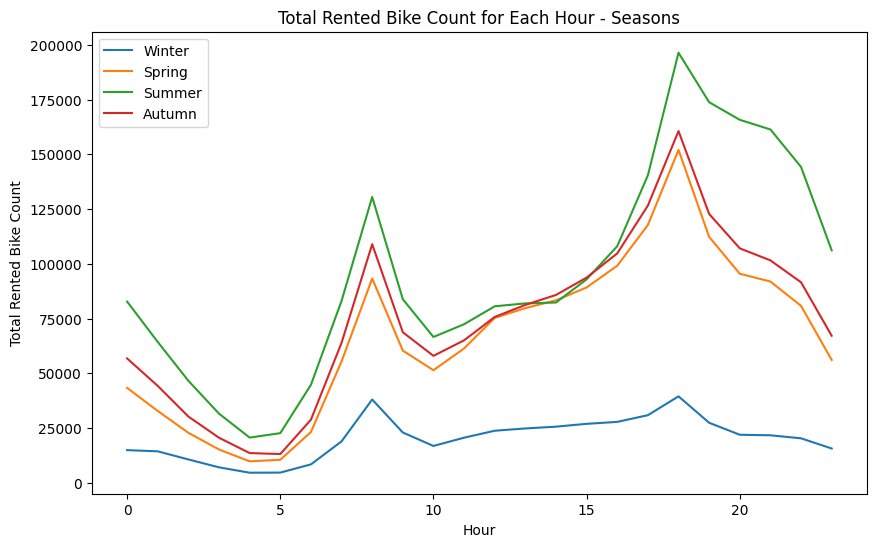

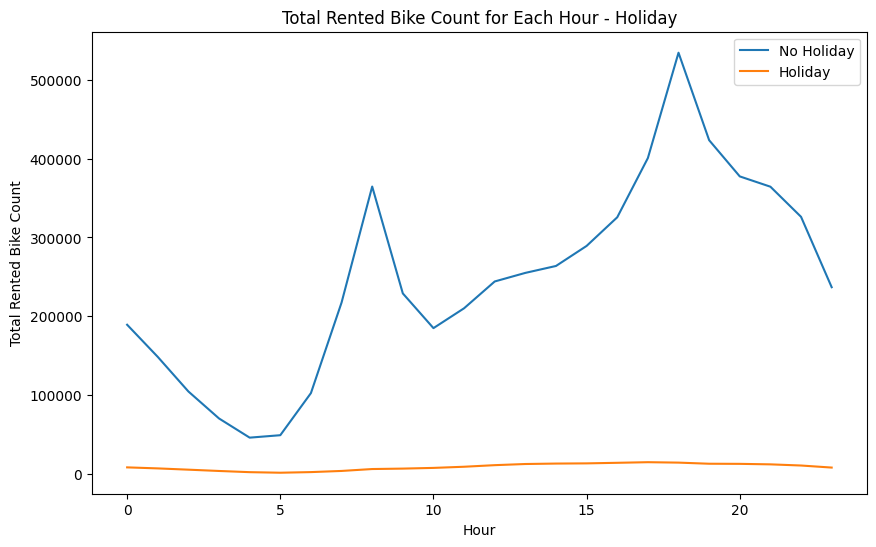

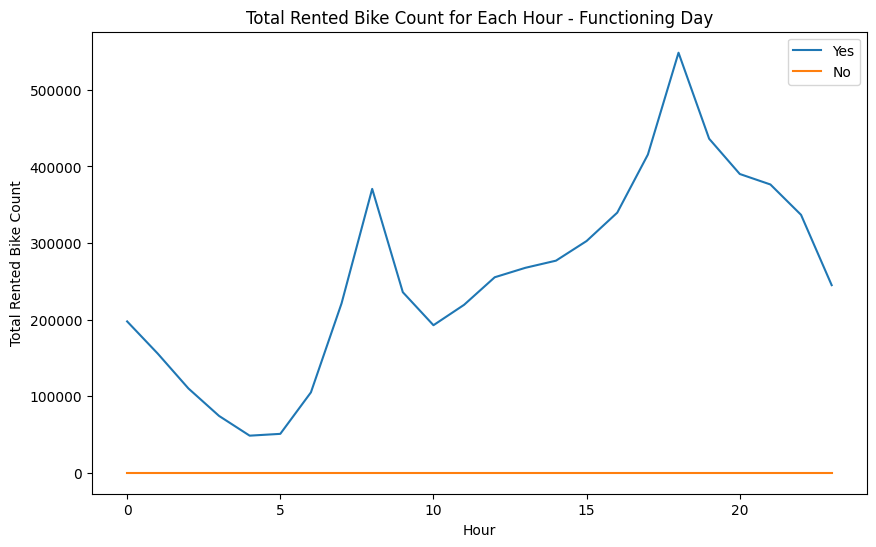

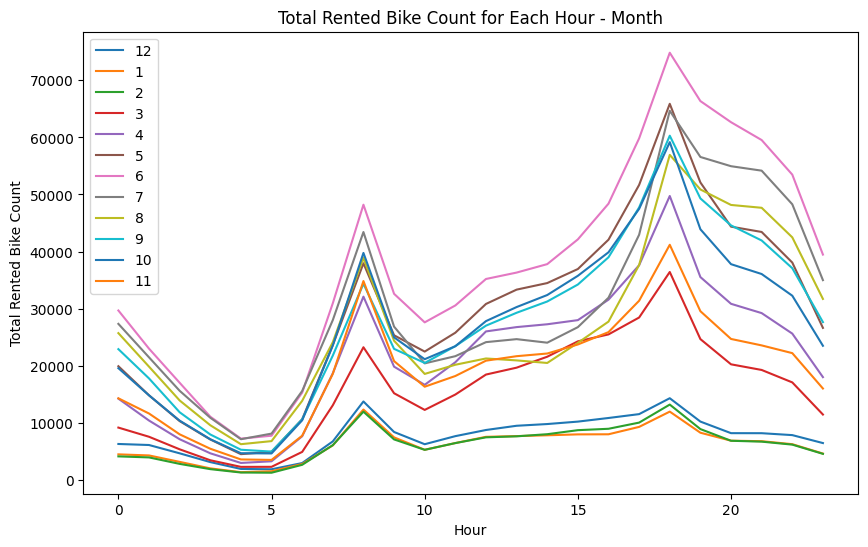

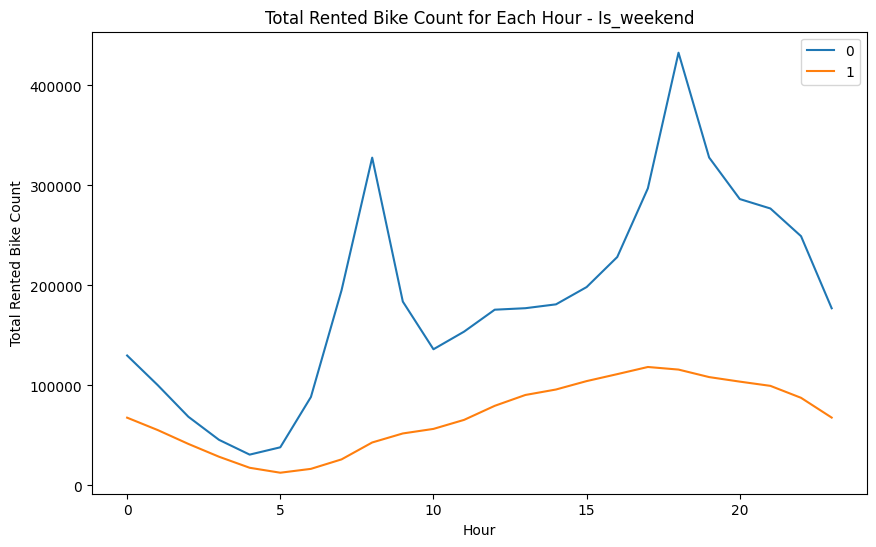

In [47]:
import matplotlib.pyplot as plt

# Iterate over the unique values of each categorical feature
for feature in categorical_features:
    if feature != 'Hour':
        unique_values = categorical_data[feature].unique()
        
        # Plot the line plot for each unique value
        plt.figure(figsize=(10, 6))
        for value in unique_values:
            value_data = data[data[feature] == value]
            total_count = value_data.groupby('Hour')['Rented Bike Count'].sum()
            plt.plot(total_count.index, total_count.values, label=value)
        
        # Set the x-axis label
        plt.xlabel('Hour')
        
        # Set the y-axis label
        plt.ylabel('Total Rented Bike Count')
        
        # Set the title of the plot
        plt.title(f'Total Rented Bike Count for Each Hour - {feature}')
        
        # Add a legend
        plt.legend()
        
        # Show the plot
        plt.show()

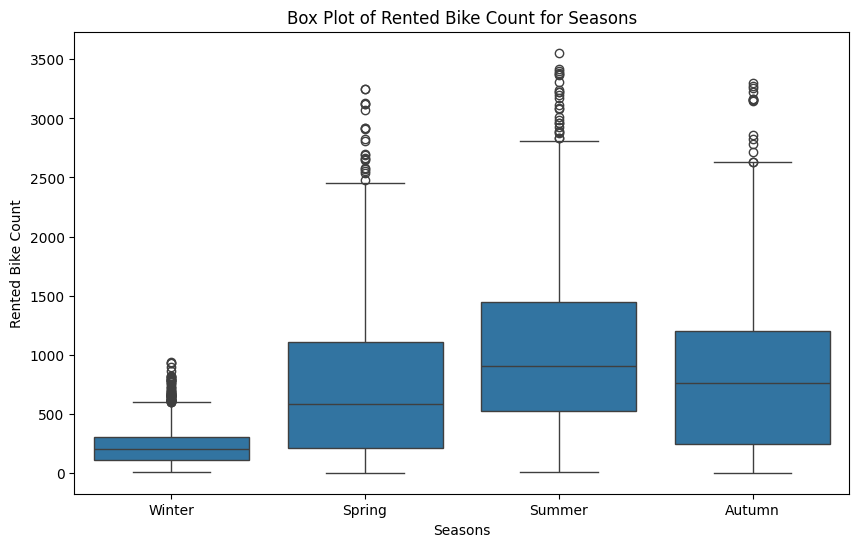

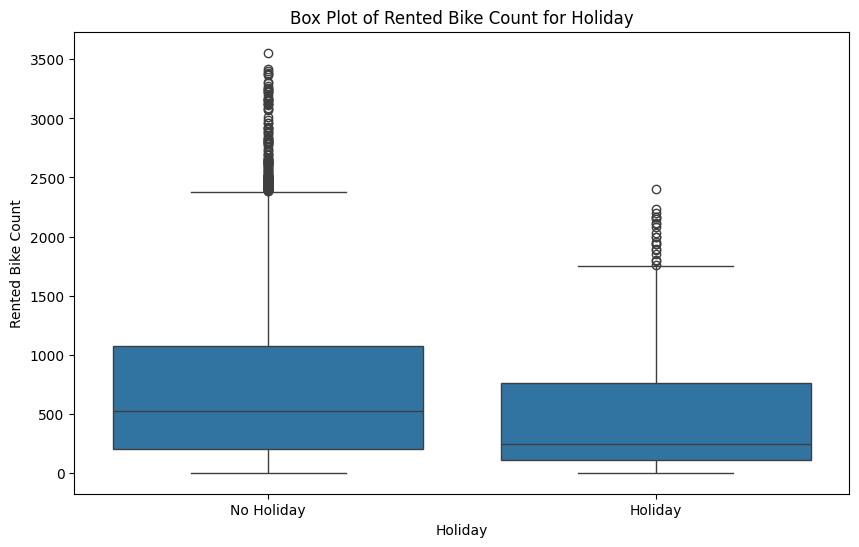

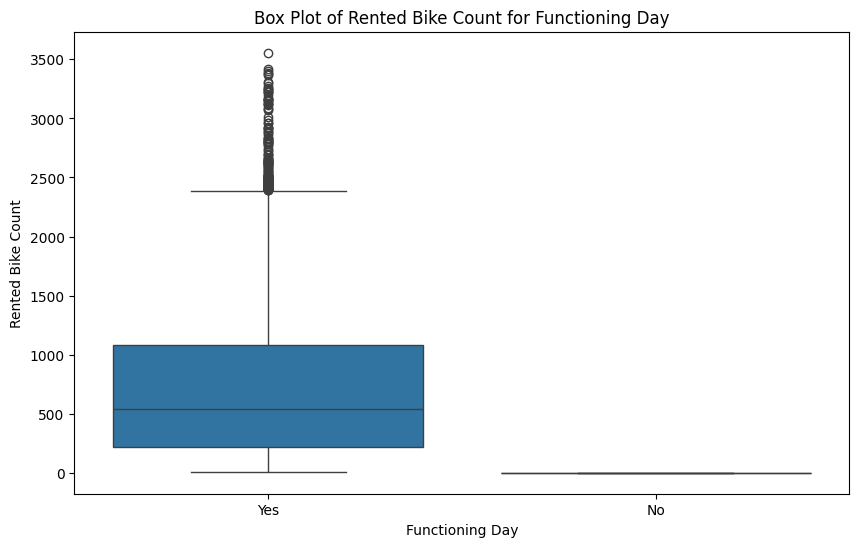

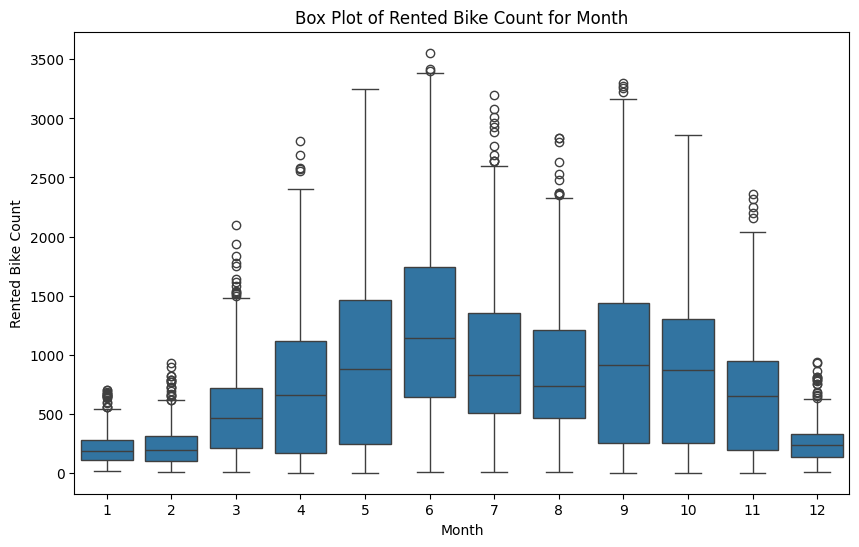

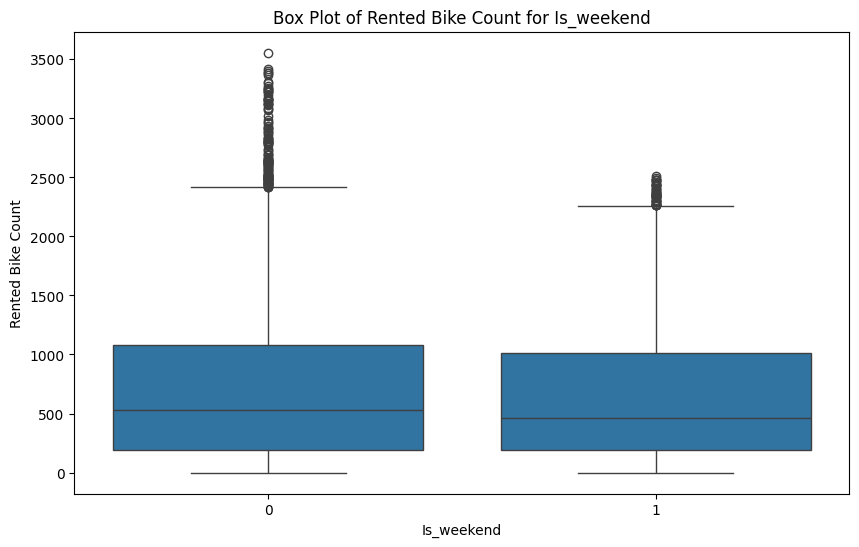

In [48]:
import seaborn as sns

import matplotlib.pyplot as plt

# Iterate over the categorical features
for feature in categorical_features:
    if feature != 'Hour':
        # Create a box plot for each unique value of the feature
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=feature, y='Rented Bike Count', data=data)
        plt.title(f'Box Plot of Rented Bike Count for {feature}')
        plt.show()

##c. Build, train, test and optimize the model
1. Seperate target and features from the data.
2. Do 80:20 train test split.
3. Train the XGBoost regression model with default parameters.
  * Report $r^2$ and RMSE values for train and test datasets.
  * Plot actual vs predicted for the test data.
  * Plot feature importance and report top 5 features (use importance_type='gain').
4. Tune the hyperparameters of the model using Optuna. Specify the parameter values used.
  * Report $r^2$ and RMSE values for train and test datasets.
  * Plot actual vs predicted for the test data.
  * Plot feature importance and report top 5 features (use importance_type='gain').

    **compare with the default model and comment**
